Epoch [10/100], Loss: 0.002489, PnL: 0.005967, Transaction Cost: 0.000844
Epoch [20/100], Loss: 0.001271, PnL: 0.004785, Transaction Cost: 0.000779
Epoch [30/100], Loss: 0.001354, PnL: -0.000374, Transaction Cost: 0.000757
Epoch [40/100], Loss: 0.000606, PnL: 0.000506, Transaction Cost: 0.000451
Epoch [50/100], Loss: 0.000398, PnL: 0.002217, Transaction Cost: 0.000290
Epoch [60/100], Loss: 0.000339, PnL: -0.000731, Transaction Cost: 0.000302
Epoch [70/100], Loss: 0.000235, PnL: 0.000178, Transaction Cost: 0.000202
Epoch [80/100], Loss: 0.000255, PnL: 0.002161, Transaction Cost: 0.000238
Epoch [90/100], Loss: 0.000174, PnL: 0.000264, Transaction Cost: 0.000169
Epoch [100/100], Loss: 0.000144, PnL: 0.000113, Transaction Cost: 0.000140


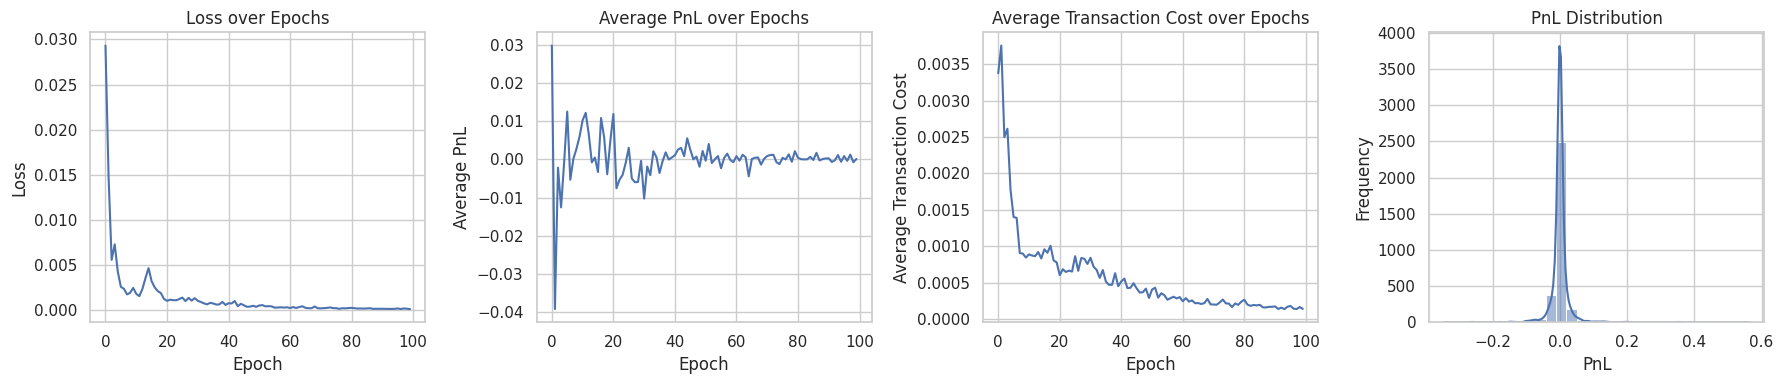

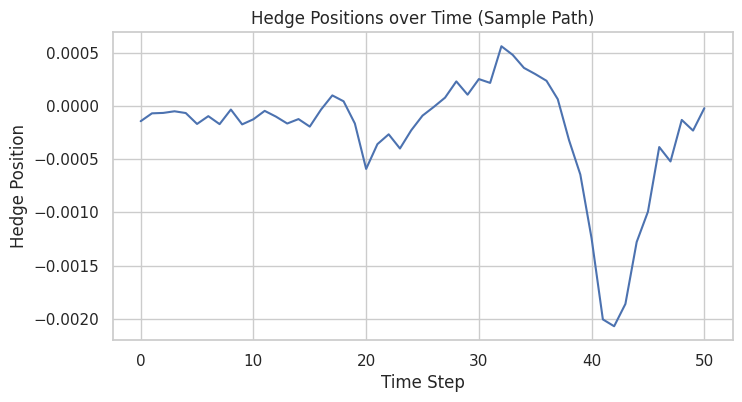

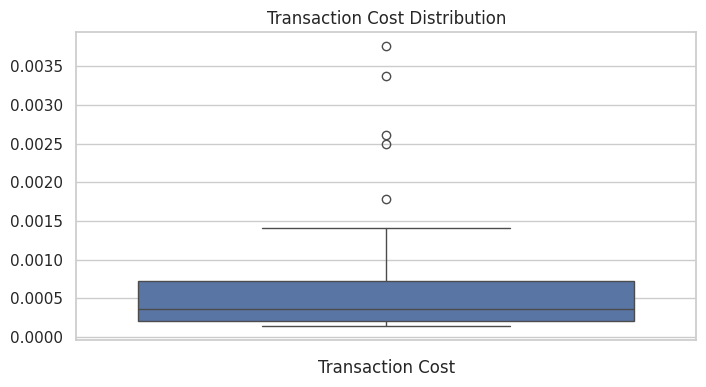

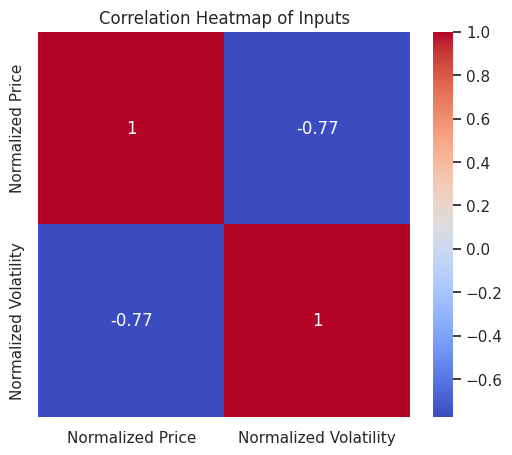

In [ ]:
# Step 1: Import Required Libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

# Configure Seaborn style
sns.set(style='whitegrid')

# Step 2: Define the Heston Model (Stochastic Volatility)
class HestonModel:
    def __init__(self, x0=1.0, v0=0.04, theta=0.04, kappa=2.0, xi=0.5, rho=-0.7, dt=1/250, T=50):
        self.x0 = x0      # Initial asset price
        self.v0 = v0      # Initial variance
        self.theta = theta  # Long-term variance level
        self.kappa = kappa  # Speed of mean reversion
        self.xi = xi        # Volatility of volatility
        self.rho = rho      # Correlation between asset and volatility
        self.dt = dt        # Time step
        self.T = T          # Total time steps

    def simulate_path(self):
        x = np.zeros(int(self.T) + 1)
        v = np.zeros(int(self.T) + 1)
        x[0] = self.x0
        v[0] = self.v0
        for t in range(1, int(self.T) + 1):
            z1 = np.random.normal()
            z2 = np.random.normal()
            dw1 = np.sqrt(self.dt) * z1
            dw2 = np.sqrt(self.dt) * (self.rho * z1 + np.sqrt(1 - self.rho**2) * z2)
            v_prev = max(v[t-1], 0)
            dv = self.kappa * (self.theta - v_prev) * self.dt + self.xi * np.sqrt(v_prev) * dw2
            v[t] = v_prev + dv
            x[t] = x[t-1] + x[t-1] * np.sqrt(v_prev) * dw1
        return x, v

# Step 3: Define the Hedging RNN with Standard Techniques
class HedgingRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(HedgingRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # Fully connected output layer
        self.fc = nn.Linear(hidden_size, output_size)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        # Initialize LSTM weights and biases
        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)  # Xavier initialization for input weights
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)      # Orthogonal initialization for hidden weights
            elif 'bias' in name:
                nn.init.constant_(param.data, 0)     # Zero biases

        # Initialize fully connected layer weights and biases
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.constant_(self.fc.bias, 0)

    def forward(self, x):
        # Forward pass through LSTM
        out, _ = self.lstm(x)

        # Pass through fully connected layer
        out = self.fc(out)

        # Use tanh activation to keep outputs in [-1, 1]
        out = torch.tanh(out)
        return out

# Step 4: Define the Loss Function
def hedging_loss(pnl, transaction_cost, gamma=1.0):
    variance = torch.var(pnl)                        # Variance of PnL
    mean_transaction_cost = torch.mean(transaction_cost)  # Mean transaction cost
    return gamma * variance + mean_transaction_cost

# Step 5: Training Function with Enhanced Visualization
def train_hedging_policy(model, optimizer, epochs=100, batch_size=32):
    model.train()
    loss_history = []
    pnl_history = []
    transaction_cost_history = []
    pnl_distributions = []
    hedge_positions_over_time = []

    for epoch in range(epochs):
        paths_x, paths_v = [], []

        # Simulate paths using the Heston model
        for _ in range(batch_size):
            heston = HestonModel(T=50)
            x, v = heston.simulate_path()
            paths_x.append(x)
            paths_v.append(v)

        # Convert simulated paths to tensors
        paths_x = torch.tensor(paths_x, dtype=torch.float32)
        paths_v = torch.tensor(paths_v, dtype=torch.float32)

        # Normalize inputs globally for stability
        mean_x = paths_x.mean()
        std_x = paths_x.std() + 1e-6
        mean_v = paths_v.mean()
        std_v = paths_v.std() + 1e-6

        paths_x = (paths_x - mean_x) / std_x
        paths_v = (paths_v - mean_v) / std_v

        # Stack price and volatility as input features
        inputs = torch.stack((paths_x, paths_v), dim=2)  # Shape: [batch_size, sequence_length, input_size]

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(inputs)  # Shape: [batch_size, sequence_length, output_size]

        # Compute hedging positions
        delta_hedge = output.squeeze(-1)  # Shape: [batch_size, sequence_length]

        # Collect hedge positions for a sample path
        if epoch == epochs - 1:  # Collect data from the last epoch
            hedge_positions_over_time = delta_hedge[0].detach().numpy()  # Take the first path as a sample

        # Calculate price changes
        price_changes = inputs[:, 1:, 0] - inputs[:, :-1, 0]  # Shape: [batch_size, sequence_length - 1]

        # Hedge positions at times t and t+1
        delta_hedge_t = delta_hedge[:, :-1]
        delta_hedge_t1 = delta_hedge[:, 1:]

        # Compute PnL
        pnl = torch.sum(delta_hedge_t * price_changes, dim=1)

        # Collect PnL for distribution plots
        pnl_distributions.extend(pnl.detach().numpy())

        # Compute transaction costs
        delta_hedge_diff = delta_hedge_t1 - delta_hedge_t
        transaction_cost = 0.01 * torch.sum(torch.abs(delta_hedge_diff), dim=1)

        # Compute loss
        loss = hedging_loss(pnl, transaction_cost, gamma=1.0)

        # Backpropagation
        loss.backward()

        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)

        # Update model parameters
        optimizer.step()

        # Record metrics for analysis
        loss_history.append(loss.item())
        pnl_history.append(pnl.detach().mean().item())
        transaction_cost_history.append(transaction_cost.detach().mean().item())

        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}, "
                  f"PnL: {pnl.mean().item():.6f}, Transaction Cost: {transaction_cost.mean().item():.6f}")

    # Plot training metrics after training
    plt.figure(figsize=(18, 4))

    # Plot Loss over Epochs
    plt.subplot(1, 4, 1)
    plt.plot(loss_history)
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # Plot Average PnL over Epochs
    plt.subplot(1, 4, 2)
    plt.plot(pnl_history)
    plt.title('Average PnL over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Average PnL')

    # Plot Average Transaction Cost over Epochs
    plt.subplot(1, 4, 3)
    plt.plot(transaction_cost_history)
    plt.title('Average Transaction Cost over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Average Transaction Cost')

    # Plot PnL Distribution
    plt.subplot(1, 4, 4)
    sns.histplot(pnl_distributions, kde=True, bins=30)
    plt.title('PnL Distribution')
    plt.xlabel('PnL')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    # Plot Hedge Positions over Time for a Sample Path
    plt.figure(figsize=(8, 4))
    plt.plot(hedge_positions_over_time)
    plt.title('Hedge Positions over Time (Sample Path)')
    plt.xlabel('Time Step')
    plt.ylabel('Hedge Position')
    plt.show()

    # Plot Transaction Cost Distribution
    plt.figure(figsize=(8, 4))
    sns.boxplot(transaction_cost_history)
    plt.title('Transaction Cost Distribution')
    plt.xlabel('Transaction Cost')
    plt.show()

    # Plot Correlation Heatmap of Inputs
    inputs_array = inputs.detach().numpy().reshape(-1, input_size)
    df_inputs = pd.DataFrame(inputs_array, columns=['Normalized Price', 'Normalized Volatility'])
    correlation_matrix = df_inputs.corr()

    plt.figure(figsize=(6, 5))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Heatmap of Inputs')
    plt.show()

# Additional Imports for DataFrames
import pandas as pd

# Step 6: Initialize and Train the Model
input_size = 2    # Number of input features (price and volatility)
hidden_size = 32  # Size of LSTM hidden state
output_size = 1   # Output size (hedge ratio)

# Instantiate the model
model = HedgingRNN(input_size, hidden_size, output_size)

# Use Adam optimizer with weight decay for regularization
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

# Train the model
train_hedging_policy(model, optimizer, epochs=100, batch_size=32)


<ipython-input-1-f599bb3ba03a>:115: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  paths_x = torch.tensor(paths_x, dtype=torch.float32)


Adam - Epoch [10/100], Loss: 0.013530, PnL Mean: 0.000411, PnL Std: 0.084928, Sharpe Ratio: 0.0048, Transaction Cost: 0.006317, Time: 0.38s
Adam - Epoch [20/100], Loss: 0.016715, PnL Mean: -0.007856, PnL Std: 0.109329, Sharpe Ratio: -0.0719, Transaction Cost: 0.004762, Time: 0.72s
Adam - Epoch [30/100], Loss: 0.006201, PnL Mean: 0.001802, PnL Std: 0.042130, Sharpe Ratio: 0.0428, Transaction Cost: 0.004426, Time: 1.06s
Adam - Epoch [40/100], Loss: 0.003589, PnL Mean: -0.000104, PnL Std: 0.017538, Sharpe Ratio: -0.0059, Transaction Cost: 0.003282, Time: 1.44s
Adam - Epoch [50/100], Loss: 0.004018, PnL Mean: 0.008489, PnL Std: 0.029047, Sharpe Ratio: 0.2923, Transaction Cost: 0.003174, Time: 1.78s
Adam - Epoch [60/100], Loss: 0.002778, PnL Mean: -0.000226, PnL Std: 0.018829, Sharpe Ratio: -0.0120, Transaction Cost: 0.002424, Time: 2.15s
Adam - Epoch [70/100], Loss: 0.002327, PnL Mean: -0.004389, PnL Std: 0.019829, Sharpe Ratio: -0.2213, Transaction Cost: 0.001934, Time: 2.46s
Adam - Epoch

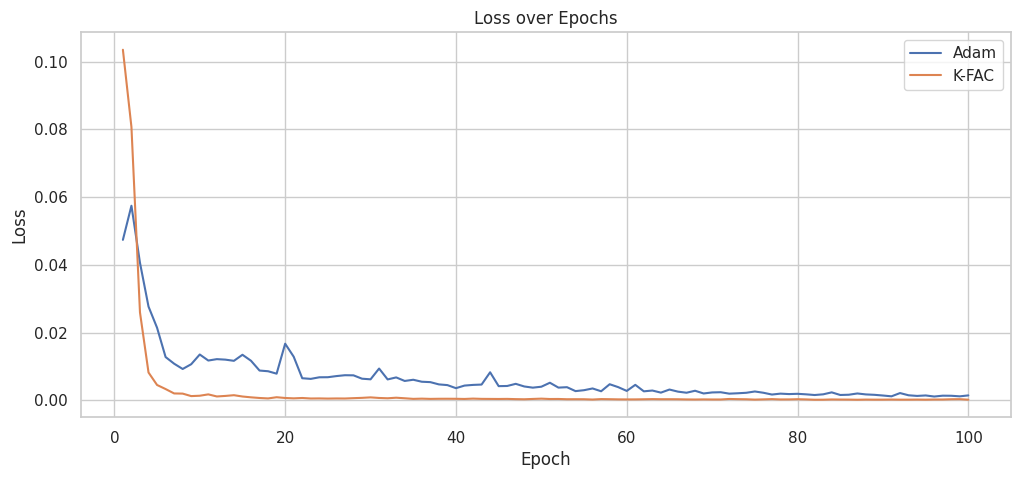

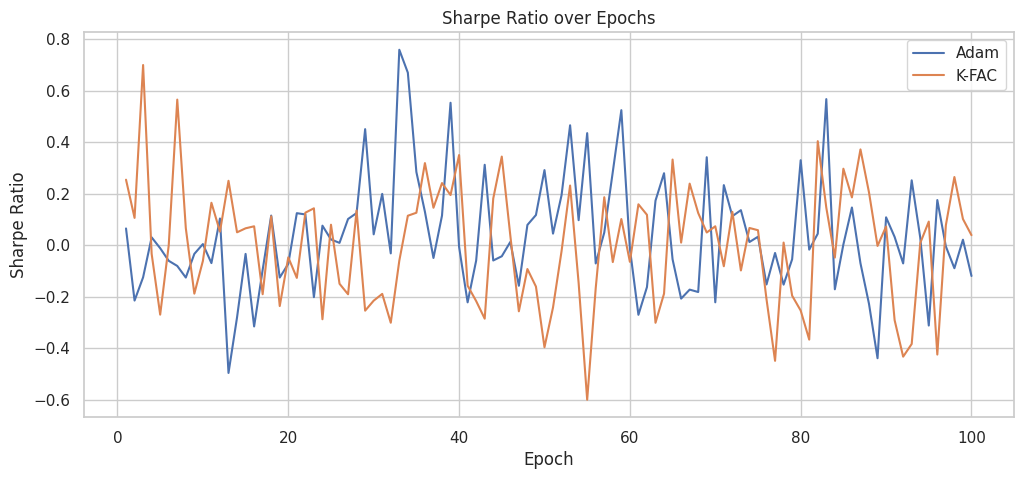

<ipython-input-1-f599bb3ba03a>:222: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(results_adam['pnl_history'], label='Adam', shade=True)
<ipython-input-1-f599bb3ba03a>:223: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(results_kfac['pnl_history'], label='K-FAC', shade=True)


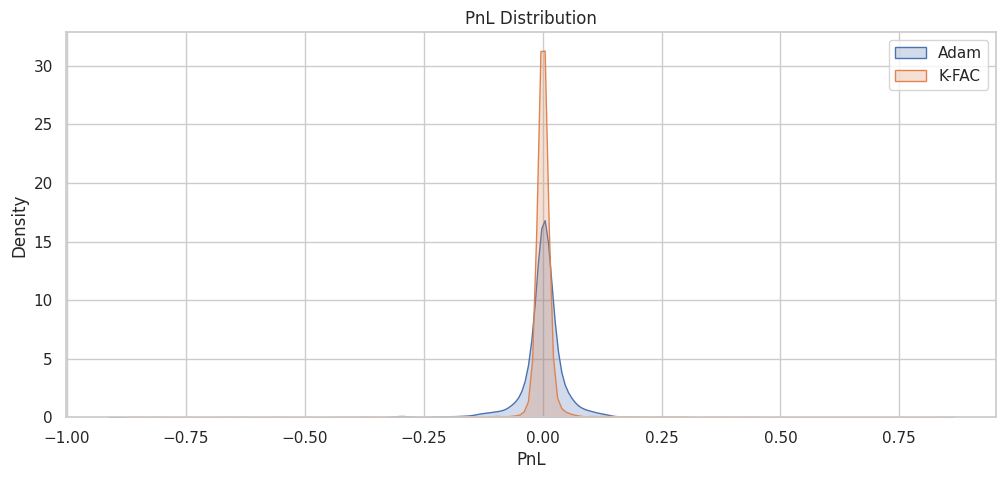

<ipython-input-1-f599bb3ba03a>:231: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(results_adam['transaction_cost_history'], label='Adam', shade=True)
<ipython-input-1-f599bb3ba03a>:232: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(results_kfac['transaction_cost_history'], label='K-FAC', shade=True)


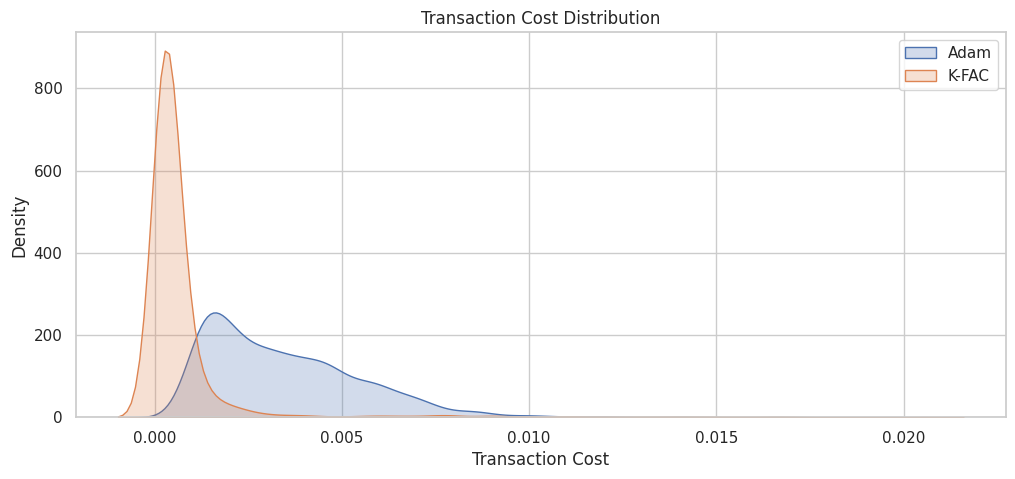

Final Performance Metrics:
Adam - Variance of PnL: 0.003176, Average Transaction Cost: 0.003432, Sharpe Ratio: -0.0025, Training Time: 3.40s
K-FAC - Variance of PnL: 0.002084, Average Transaction Cost: 0.000745, Sharpe Ratio: 0.0401, Training Time: 3.29s

Statistical Significance Tests:
PnL Comparison - t-statistic: -1.5372, p-value: 0.1243
Transaction Cost Comparison - t-statistic: 56.8776, p-value: 0.0000


In [1]:
# Import required libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy import stats

# Configure Seaborn style
sns.set(style='whitegrid')

# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Step 1: Define the Heston Model (Same as before)
class HestonModel:
    def __init__(self, x0=1.0, v0=0.04, theta=0.04, kappa=2.0, xi=0.5, rho=-0.7, dt=1/250, T=50):
        self.x0 = x0      # Initial asset price
        self.v0 = v0      # Initial variance
        self.theta = theta  # Long-term variance level
        self.kappa = kappa  # Speed of mean reversion
        self.xi = xi        # Volatility of volatility
        self.rho = rho      # Correlation between asset and volatility
        self.dt = dt        # Time step
        self.T = T          # Total time steps

    def simulate_path(self):
        x = np.zeros(int(self.T) + 1)
        v = np.zeros(int(self.T) + 1)
        x[0] = self.x0
        v[0] = self.v0
        for t in range(1, int(self.T) + 1):
            z1 = np.random.normal()
            z2 = np.random.normal()
            dw1 = np.sqrt(self.dt) * z1
            dw2 = np.sqrt(self.dt) * (self.rho * z1 + np.sqrt(1 - self.rho**2) * z2)
            v_prev = max(v[t-1], 0)
            dv = self.kappa * (self.theta - v_prev) * self.dt + self.xi * np.sqrt(v_prev) * dw2
            v[t] = v_prev + dv
            x[t] = x[t-1] + x[t-1] * np.sqrt(v_prev) * dw1
        return x, v

# Step 2: Define the Hedging RNN (Same as before)
class HedgingRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(HedgingRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # Fully connected output layer
        self.fc = nn.Linear(hidden_size, output_size)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        # Initialize LSTM weights and biases
        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)  # Xavier initialization for input weights
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)      # Orthogonal initialization for hidden weights
            elif 'bias' in name:
                nn.init.constant_(param.data, 0)     # Zero biases

        # Initialize fully connected layer weights and biases
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.constant_(self.fc.bias, 0)

    def forward(self, x):
        # Forward pass through LSTM
        out, _ = self.lstm(x)

        # Pass through fully connected layer
        out = self.fc(out)

        # Use tanh activation to keep outputs in [-1, 1]
        out = torch.tanh(out)
        return out

# Step 3: Define the Loss Function (Same as before)
def hedging_loss(pnl, transaction_cost, gamma=1.0):
    variance = torch.var(pnl)                        # Variance of P&L
    mean_transaction_cost = torch.mean(transaction_cost)  # Mean transaction cost
    return gamma * variance + mean_transaction_cost

# Step 4: Training Function with Enhanced Visualization
def train_hedging_policy(model, optimizer, epochs=100, batch_size=32, optimizer_name='Optimizer'):
    model.train()
    loss_history = []
    pnl_history = []
    transaction_cost_history = []
    sharpe_ratio_history = []
    training_time = 0

    start_time = time.time()

    for epoch in range(epochs):
        paths_x, paths_v = [], []

        # Simulate paths using the Heston model
        for _ in range(batch_size):
            heston = HestonModel(T=50)
            x, v = heston.simulate_path()
            paths_x.append(x)
            paths_v.append(v)

        # Convert simulated paths to tensors
        paths_x = torch.tensor(paths_x, dtype=torch.float32)
        paths_v = torch.tensor(paths_v, dtype=torch.float32)

        # Normalize inputs globally for stability
        mean_x = paths_x.mean()
        std_x = paths_x.std() + 1e-6
        mean_v = paths_v.mean()
        std_v = paths_v.std() + 1e-6

        paths_x = (paths_x - mean_x) / std_x
        paths_v = (paths_v - mean_v) / std_v

        # Stack price and volatility as input features
        inputs = torch.stack((paths_x, paths_v), dim=2)  # Shape: [batch_size, sequence_length, input_size]

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(inputs)  # Shape: [batch_size, sequence_length, output_size]

        # Compute hedging positions
        delta_hedge = output.squeeze(-1)  # Shape: [batch_size, sequence_length]

        # Calculate price changes
        price_changes = inputs[:, 1:, 0] - inputs[:, :-1, 0]  # Shape: [batch_size, sequence_length - 1]

        # Hedge positions at times t and t+1
        delta_hedge_t = delta_hedge[:, :-1]
        delta_hedge_t1 = delta_hedge[:, 1:]

        # Compute PnL
        pnl = torch.sum(delta_hedge_t * price_changes, dim=1)

        # Compute transaction costs
        delta_hedge_diff = delta_hedge_t1 - delta_hedge_t
        transaction_cost = 0.01 * torch.sum(torch.abs(delta_hedge_diff), dim=1)

        # Compute loss
        loss = hedging_loss(pnl, transaction_cost, gamma=1.0)

        # Backpropagation
        loss.backward()

        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)

        # Update model parameters
        optimizer.step()

        # Record metrics for analysis
        loss_history.append(loss.item())
        pnl_history.extend(pnl.detach().numpy())
        transaction_cost_history.extend(transaction_cost.detach().numpy())

        # Compute Sharpe Ratio (Assuming risk-free rate is 0)
        pnl_mean = pnl.mean().item()
        pnl_std = pnl.std().item()
        sharpe_ratio = pnl_mean / (pnl_std + 1e-6)
        sharpe_ratio_history.append(sharpe_ratio)

        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            elapsed_time = time.time() - start_time
            print(f"{optimizer_name} - Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}, "
                  f"PnL Mean: {pnl_mean:.6f}, PnL Std: {pnl_std:.6f}, Sharpe Ratio: {sharpe_ratio:.4f}, "
                  f"Transaction Cost: {transaction_cost.mean().item():.6f}, Time: {elapsed_time:.2f}s")

    training_time = time.time() - start_time

    # Store results in a dictionary
    results = {
        'loss_history': loss_history,
        'pnl_history': pnl_history,
        'transaction_cost_history': transaction_cost_history,
        'sharpe_ratio_history': sharpe_ratio_history,
        'training_time': training_time
    }

    return results

# Step 5: Define Function to Plot Results
def plot_results(results_adam, results_kfac):
    epochs = range(1, len(results_adam['loss_history']) + 1)

    # Plot Loss over Epochs
    plt.figure(figsize=(12, 5))
    plt.plot(epochs, results_adam['loss_history'], label='Adam')
    plt.plot(epochs, results_kfac['loss_history'], label='K-FAC')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot Sharpe Ratio over Epochs
    plt.figure(figsize=(12, 5))
    plt.plot(epochs, results_adam['sharpe_ratio_history'], label='Adam')
    plt.plot(epochs, results_kfac['sharpe_ratio_history'], label='K-FAC')
    plt.title('Sharpe Ratio over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Sharpe Ratio')
    plt.legend()
    plt.show()

    # Plot PnL Distributions
    plt.figure(figsize=(12, 5))
    sns.kdeplot(results_adam['pnl_history'], label='Adam', shade=True)
    sns.kdeplot(results_kfac['pnl_history'], label='K-FAC', shade=True)
    plt.title('PnL Distribution')
    plt.xlabel('PnL')
    plt.legend()
    plt.show()

    # Plot Transaction Cost Distributions
    plt.figure(figsize=(12, 5))
    sns.kdeplot(results_adam['transaction_cost_history'], label='Adam', shade=True)
    sns.kdeplot(results_kfac['transaction_cost_history'], label='K-FAC', shade=True)
    plt.title('Transaction Cost Distribution')
    plt.xlabel('Transaction Cost')
    plt.legend()
    plt.show()

# Step 6: Training and Comparing Models

# Initialize models with the same architecture
input_size = 2    # Number of input features (price and volatility)
hidden_size = 32  # Size of LSTM hidden state
output_size = 1   # Output size (hedge ratio)

# Adam optimizer model
model_adam = HedgingRNN(input_size, hidden_size, output_size)
optimizer_adam = optim.Adam(model_adam.parameters(), lr=1e-3, weight_decay=1e-4)

# K-FAC optimizer model
model_kfac = HedgingRNN(input_size, hidden_size, output_size)

# Define the K-FAC optimizer
class KFACOptimizer(optim.Optimizer):
    def __init__(self, model, lr=1e-3, damping=1e-2):
        defaults = dict(lr=lr, damping=damping)
        super(KFACOptimizer, self).__init__(model.parameters(), defaults)
        self.model = model
        self.damping = damping
        self.lr = lr

    def step(self):
        # Only apply K-FAC to the fully connected layer
        layer = self.model.fc

        # Get activations and gradients
        A = self.model.activations[-2]  # Activation before FC layer
        G = self.model.activations[-1].grad  # Gradient at the output

        # Reshape activations and gradients
        batch_size, sequence_length, hidden_size = A.size()
        A = A.reshape(-1, hidden_size)  # Shape: [batch_size * seq_length, hidden_size]
        G = G.reshape(-1, layer.out_features)  # Shape: [batch_size * seq_length, output_size]

        # Compute Kronecker factors
        A_factor = torch.matmul(A.t(), A) / A.size(0)  # [hidden_size, hidden_size]
        G_factor = torch.matmul(G.t(), G) / G.size(0)  # [output_size, output_size]

        # Add damping
        damping = self.damping
        A_factor += damping * torch.eye(A_factor.size(0))
        G_factor += damping * torch.eye(G_factor.size(0))

        # Use SVD for stable inversion
        try:
            U_a, S_a, V_a = torch.svd(A_factor)
            A_inv = V_a @ torch.diag(1.0 / S_a) @ U_a.t()
        except RuntimeError:
            A_inv = torch.linalg.pinv(A_factor)

        try:
            U_g, S_g, V_g = torch.svd(G_factor)
            G_inv = V_g @ torch.diag(1.0 / S_g) @ U_g.t()
        except RuntimeError:
            G_inv = torch.linalg.pinv(G_factor)

        # Get gradients of weights and biases
        grad_weight = layer.weight.grad  # Shape: [output_size, hidden_size]
        grad_bias = layer.bias.grad  # Shape: [output_size]

        # Precondition gradients
        precon_grad_weight = G_inv @ grad_weight @ A_inv
        precon_grad_bias = G_inv @ grad_bias.unsqueeze(1)

        # Update parameters
        layer.weight.data -= self.lr * precon_grad_weight
        layer.bias.data -= self.lr * precon_grad_bias.squeeze()

        # Zero gradients after update
        self.model.zero_grad()

optimizer_kfac = KFACOptimizer(model_kfac, lr=1e-3, damping=1e-2)

# Add activations storage to the model
def forward_with_activations(self, x):
    self.activations = []
    out, _ = self.lstm(x)
    out.retain_grad()
    self.activations.append(out)
    out = self.fc(out)
    out.retain_grad()
    self.activations.append(out)
    out = torch.tanh(out)
    return out

# Replace the forward method
model_kfac.forward = forward_with_activations.__get__(model_kfac, HedgingRNN)

# Train models
results_adam = train_hedging_policy(model_adam, optimizer_adam, epochs=100, batch_size=32, optimizer_name='Adam')
results_kfac = train_hedging_policy(model_kfac, optimizer_kfac, epochs=100, batch_size=32, optimizer_name='K-FAC')

# Plot results
plot_results(results_adam, results_kfac)

# Step 7: Statistical Analysis

# Compute final metrics
def compute_final_metrics(results):
    pnl = np.array(results['pnl_history'])
    transaction_costs = np.array(results['transaction_cost_history'])
    sharpe_ratio = np.mean(pnl) / (np.std(pnl) + 1e-6)
    variance_pnl = np.var(pnl)
    avg_transaction_cost = np.mean(transaction_costs)
    return variance_pnl, avg_transaction_cost, sharpe_ratio

variance_pnl_adam, avg_transaction_cost_adam, sharpe_ratio_adam = compute_final_metrics(results_adam)
variance_pnl_kfac, avg_transaction_cost_kfac, sharpe_ratio_kfac = compute_final_metrics(results_kfac)

print("Final Performance Metrics:")
print(f"Adam - Variance of PnL: {variance_pnl_adam:.6f}, Average Transaction Cost: {avg_transaction_cost_adam:.6f}, Sharpe Ratio: {sharpe_ratio_adam:.4f}, Training Time: {results_adam['training_time']:.2f}s")
print(f"K-FAC - Variance of PnL: {variance_pnl_kfac:.6f}, Average Transaction Cost: {avg_transaction_cost_kfac:.6f}, Sharpe Ratio: {sharpe_ratio_kfac:.4f}, Training Time: {results_kfac['training_time']:.2f}s")

# Perform t-tests on PnL and Transaction Costs
t_stat_pnl, p_value_pnl = stats.ttest_ind(results_adam['pnl_history'], results_kfac['pnl_history'], equal_var=False)
t_stat_tc, p_value_tc = stats.ttest_ind(results_adam['transaction_cost_history'], results_kfac['transaction_cost_history'], equal_var=False)

print("\nStatistical Significance Tests:")
print(f"PnL Comparison - t-statistic: {t_stat_pnl:.4f}, p-value: {p_value_pnl:.4f}")
print(f"Transaction Cost Comparison - t-statistic: {t_stat_tc:.4f}, p-value: {p_value_tc:.4f}")
